# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 05 Dec 2019

# Imports

In [332]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [212]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
test_fraction = 0.2
runs = 30

# Helper functions

In [5]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    else:
        raise ValueError('Wrong type_str was given.')

# Loading the data

In [6]:
data = utils.load_it(data_fpath)
print(len(data['X']))

337


In [7]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'] / 100)

In [8]:
np.mean(mats, axis=0)

array([[0.26338279, 0.24830861, 0.25548961, 0.23243323],
       [0.2189911 , 0.33845697, 0.2158457 , 0.2227003 ],
       [0.21379822, 0.2511276 , 0.30367953, 0.22474777],
       [0.25338279, 0.24091988, 0.24379822, 0.26367953]])

In [9]:
np.std(mats, axis=0)

array([[0.12754406, 0.08032826, 0.09008641, 0.07827526],
       [0.10004831, 0.19647938, 0.08964129, 0.11201212],
       [0.09734972, 0.12308318, 0.17451618, 0.10372017],
       [0.0940633 , 0.06791981, 0.06305615, 0.09161002]])

# Formulating the tower model

## Only content embeddings

In [318]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
#             flatten_X_train.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_train.append(features['content_embedding_matrix'].flatten())
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
#             flatten_X_test.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_test.append(features['content_embedding_matrix'].flatten())
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3072,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(16, kernel_initializer='he_normal', activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.8295 - accuracy: 0.0170
Epoch 2/10
269/269 [==============================] - 0s 127us/sample - loss: 0.7408 - accuracy: 0.0170
Epoch 3/10
269/269 [==============================] - 0s 102us/sample - loss: 0.7446 - accuracy: 0.0170
Epoch 4/10
269/269 [==============================] - 0s 86us/sample - loss: 0.7402 - accuracy: 0.0170
Epoch 5/10
269/269 [==============================] - 0s 98us/sample - loss: 0.7399 - accuracy: 0.0170
Epoch 6/10
269/269 [==============================] - 0s 90us/sample - loss: 0.7396 - accuracy: 0.0170
Epoch 7/10
269/269 [==============================] - 0s 86us/sample - loss: 0.7395 - accuracy: 0.0170
Epoch 8/10
269/269 [==============================] - 0s 83us/sample - loss: 0.7394 - accuracy: 0.0170
Epoch 9/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7393 - accuracy: 0.0170
Epoch 10/10
269/269 [====================

269/269 [==============================] - 0s 68us/sample - loss: 0.7391 - accuracy: 0.0158
Epoch 9/10
269/269 [==============================] - 0s 71us/sample - loss: 0.7390 - accuracy: 0.0158
Epoch 10/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7389 - accuracy: 0.0158
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.8302 - accuracy: 0.0191
Epoch 2/10
269/269 [==============================] - 0s 70us/sample - loss: 0.7431 - accuracy: 0.0193
Epoch 3/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7397 - accuracy: 0.0193
Epoch 4/10
269/269 [==============================] - 0s 63us/sample - loss: 0.7395 - accuracy: 0.0193
Epoch 5/10
269/269 [==============================] - 0s 60us/sample - loss: 0.7393 - accuracy: 0.0193
Epoch 6/10
269/269 [==============================] - 0s 64us/sample - loss: 0.7391 - accuracy: 0.0193
Epoch 7/10
269/269 [==============================] -

269/269 [==============================] - 0s 79us/sample - loss: 0.7396 - accuracy: 0.0184
Epoch 6/10
269/269 [==============================] - 0s 68us/sample - loss: 0.7395 - accuracy: 0.0184
Epoch 7/10
269/269 [==============================] - 0s 66us/sample - loss: 0.7394 - accuracy: 0.0184
Epoch 8/10
269/269 [==============================] - 0s 68us/sample - loss: 0.7392 - accuracy: 0.0184
Epoch 9/10
269/269 [==============================] - 0s 63us/sample - loss: 0.7392 - accuracy: 0.0184
Epoch 10/10
269/269 [==============================] - 0s 63us/sample - loss: 0.7390 - accuracy: 0.0184
Run 16 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.8180 - accuracy: 0.0170
Epoch 2/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7408 - accuracy: 0.0170
Epoch 3/10
269/269 [==============================] - 0s 75us/sample - loss: 0.7394 - accuracy: 0.0170
Epoch 4/10
269/269 [==============================] 

269/269 [==============================] - 0s 102us/sample - loss: 0.7411 - accuracy: 0.0195
Epoch 3/10
269/269 [==============================] - 0s 105us/sample - loss: 0.7397 - accuracy: 0.0195
Epoch 4/10
269/269 [==============================] - 0s 96us/sample - loss: 0.7397 - accuracy: 0.0195
Epoch 5/10
269/269 [==============================] - 0s 87us/sample - loss: 0.7400 - accuracy: 0.0195
Epoch 6/10
269/269 [==============================] - 0s 83us/sample - loss: 0.7391 - accuracy: 0.0195
Epoch 7/10
269/269 [==============================] - 0s 80us/sample - loss: 0.7389 - accuracy: 0.0195
Epoch 8/10
269/269 [==============================] - 0s 77us/sample - loss: 0.7387 - accuracy: 0.0195
Epoch 9/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7386 - accuracy: 0.0195
Epoch 10/10
269/269 [==============================] - 0s 72us/sample - loss: 0.7386 - accuracy: 0.0195
Run 24 ...
Train on 269 samples
Epoch 1/10
269/269 [=============================

random: 0.631026874981446 +- 0.013433107688312273
uniform: 0.3504242268432317 +- 0.017263519200923328
model: 0.34571035693852015 +- 0.016304089815225024


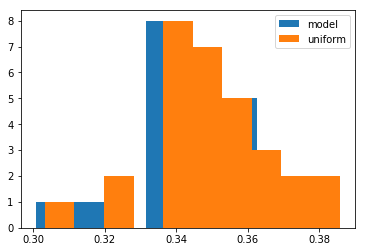

In [319]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## Only networks

In [320]:
all_networks = True
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 80
lambda1 = 1

In [327]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim,),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=64,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)
        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1158.2696 - accuracy: 0.1250
Epoch 2/10
269/269 [==============================] - 0s 102us/sample - loss: 1092.7397 - accuracy: 0.1250
Epoch 3/10
269/269 [==============================] - 0s 100us/sample - loss: 1030.5301 - accuracy: 0.1250
Epoch 4/10
269/269 [==============================] - 0s 86us/sample - loss: 971.0058 - accuracy: 0.1250
Epoch 5/10
269/269 [==============================] - 0s 78us/sample - loss: 914.2789 - accuracy: 0.1250
Epoch 6/10
269/269 [==============================] - 0s 73us/sample - loss: 859.5781 - accuracy: 0.1250
Epoch 7/10
269/269 [==============================] - 0s 71us/sample - loss: 807.3868 - accuracy: 0.1250
Epoch 8/10
269/269 [==============================] - 0s 62us/sample - loss: 757.8414 - accuracy: 0.1250
Epoch 9/10
269/269 [==============================] - 0s 60us/sample - loss: 710.2078 - accuracy: 0.1250
Epoch 10/10
269/269 

269/269 [==============================] - 0s 66us/sample - loss: 963.8888 - accuracy: 0.0000e+00
Epoch 5/10
269/269 [==============================] - 0s 68us/sample - loss: 907.6850 - accuracy: 0.0000e+00
Epoch 6/10
269/269 [==============================] - 0s 71us/sample - loss: 853.1341 - accuracy: 0.0000e+00
Epoch 7/10
269/269 [==============================] - 0s 71us/sample - loss: 801.1838 - accuracy: 0.0000e+00
Epoch 8/10
269/269 [==============================] - 0s 61us/sample - loss: 751.2782 - accuracy: 0.0000e+00
Epoch 9/10
269/269 [==============================] - 0s 63us/sample - loss: 703.5175 - accuracy: 0.0000e+00
Epoch 10/10
269/269 [==============================] - 0s 61us/sample - loss: 658.1808 - accuracy: 0.0000e+00
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1173.7493 - accuracy: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 0s 74us/sample - loss: 1107.2034 - accuracy: 0.0000e+

269/269 [==============================] - 0s 60us/sample - loss: 793.5151 - accuracy: 0.0000e+00
Epoch 8/10
269/269 [==============================] - 0s 68us/sample - loss: 744.0414 - accuracy: 0.0000e+00
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 696.8208 - accuracy: 0.0000e+00
Epoch 10/10
269/269 [==============================] - 0s 67us/sample - loss: 652.1692 - accuracy: 0.0000e+00
Run 15 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1151.3885 - accuracy: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 0s 71us/sample - loss: 1084.7052 - accuracy: 0.0000e+00
Epoch 3/10
269/269 [==============================] - 0s 74us/sample - loss: 1021.7938 - accuracy: 0.0000e+00
Epoch 4/10
269/269 [==============================] - 0s 56us/sample - loss: 962.0848 - accuracy: 0.0000e+00
Epoch 5/10
269/269 [==============================] - 0s 56us/sample - loss: 904.8407 - accuracy: 0.0000

269/269 [==============================] - 0s 53us/sample - loss: 666.3411 - accuracy: 0.2500
Run 22 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1149.2103 - accuracy: 0.2514
Epoch 2/10
269/269 [==============================] - 0s 78us/sample - loss: 1084.9285 - accuracy: 0.2502
Epoch 3/10
269/269 [==============================] - 0s 72us/sample - loss: 1023.0542 - accuracy: 0.2505
Epoch 4/10
269/269 [==============================] - 0s 66us/sample - loss: 963.1736 - accuracy: 0.2502
Epoch 5/10
269/269 [==============================] - 0s 63us/sample - loss: 906.3562 - accuracy: 0.2500
Epoch 6/10
269/269 [==============================] - 0s 56us/sample - loss: 851.9677 - accuracy: 0.2500
Epoch 7/10
269/269 [==============================] - 0s 68us/sample - loss: 799.8569 - accuracy: 0.2500
Epoch 8/10
269/269 [==============================] - 0s 61us/sample - loss: 749.9202 - accuracy: 0.2500
Epoch 9/10
269/269 [============

269/269 [==============================] - 0s 72us/sample - loss: 1030.0847 - accuracy: 0.0625
Epoch 4/10
269/269 [==============================] - 0s 75us/sample - loss: 970.2761 - accuracy: 0.0625
Epoch 5/10
269/269 [==============================] - 0s 70us/sample - loss: 913.2369 - accuracy: 0.0625
Epoch 6/10
269/269 [==============================] - 0s 65us/sample - loss: 858.2467 - accuracy: 0.0625
Epoch 7/10
269/269 [==============================] - 0s 54us/sample - loss: 805.8099 - accuracy: 0.0625
Epoch 8/10
269/269 [==============================] - 0s 58us/sample - loss: 755.3972 - accuracy: 0.0625
Epoch 9/10
269/269 [==============================] - 0s 55us/sample - loss: 707.3408 - accuracy: 0.0625
Epoch 10/10
269/269 [==============================] - 0s 58us/sample - loss: 661.5491 - accuracy: 0.0625
It took 45.98 seconds.


random: 0.6327249524274109 +- 0.017162693532443443
uniform: 0.3533156935131415 +- 0.01815789146330699
model: 0.3570876090926867 +- 0.017335393332607744


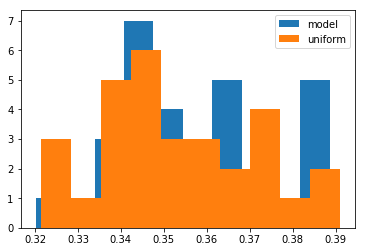

In [328]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# with Convolutional layers

In [362]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(np.reshape(flatten_X_train, (len(flatten_X_train), 80, 1)), flatten_y_train, epochs=10, batch_size=32)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), 80, 1)))

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 2900.0038 - accuracy: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 0s 239us/sample - loss: 2480.0622 - accuracy: 0.0000e+00
Epoch 3/10
269/269 [==============================] - 0s 198us/sample - loss: 2234.6507 - accuracy: 0.0000e+00
Epoch 4/10
269/269 [==============================] - 0s 185us/sample - loss: 2053.1613 - accuracy: 0.0000e+00
Epoch 5/10
269/269 [==============================] - 0s 169us/sample - loss: 1903.8771 - accuracy: 0.0000e+00
Epoch 6/10
269/269 [==============================] - 0s 166us/sample - loss: 1773.2657 - accuracy: 0.0000e+00
Epoch 7/10
269/269 [==============================] - 0s 152us/sample - loss: 1656.0913 - accuracy: 0.0000e+00
Epoch 8/10
269/269 [==============================] - 0s 161us/sample - loss: 1548.4245 - accuracy: 0.0000e+00
Epoch 9/10
269/269 [==============================] - 0s 172us/sample - loss: 1450.

269/269 [==============================] - 0s 189us/sample - loss: 2298.5910 - accuracy: 0.0625
Epoch 4/10
269/269 [==============================] - 0s 178us/sample - loss: 2105.7033 - accuracy: 0.0625
Epoch 5/10
269/269 [==============================] - 0s 163us/sample - loss: 1948.0514 - accuracy: 0.0625
Epoch 6/10
269/269 [==============================] - 0s 158us/sample - loss: 1813.2621 - accuracy: 0.0625
Epoch 7/10
269/269 [==============================] - 0s 156us/sample - loss: 1694.9948 - accuracy: 0.0625
Epoch 8/10
269/269 [==============================] - 0s 151us/sample - loss: 1587.6610 - accuracy: 0.0625
Epoch 9/10
269/269 [==============================] - 0s 152us/sample - loss: 1489.0325 - accuracy: 0.0625
Epoch 10/10
269/269 [==============================] - 0s 158us/sample - loss: 1397.7019 - accuracy: 0.0625
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 2730.5065 - accuracy: 0.0000e+00
Epoch 2/10
269

269/269 [==============================] - 0s 153us/sample - loss: 1921.3828 - accuracy: 0.0000e+00
Epoch 6/10
269/269 [==============================] - 0s 156us/sample - loss: 1793.0422 - accuracy: 0.0000e+00
Epoch 7/10
269/269 [==============================] - 0s 153us/sample - loss: 1679.0925 - accuracy: 0.0000e+00
Epoch 8/10
269/269 [==============================] - 0s 151us/sample - loss: 1575.6175 - accuracy: 0.0000e+00
Epoch 9/10
269/269 [==============================] - 0s 150us/sample - loss: 1480.2579 - accuracy: 0.0000e+00
Epoch 10/10
269/269 [==============================] - 0s 147us/sample - loss: 1392.4689 - accuracy: 0.0000e+00
Run 15 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 2766.5544 - accuracy: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 0s 208us/sample - loss: 2394.7635 - accuracy: 0.0000e+00
Epoch 3/10
269/269 [==============================] - 0s 180us/sample - loss: 2165.0482 - ac

269/269 [==============================] - 0s 166us/sample - loss: 1715.8793 - accuracy: 0.0000e+00
Epoch 8/10
269/269 [==============================] - 0s 167us/sample - loss: 1604.3191 - accuracy: 0.0000e+00
Epoch 9/10
269/269 [==============================] - 0s 164us/sample - loss: 1501.3767 - accuracy: 0.0000e+00
Epoch 10/10
269/269 [==============================] - 0s 163us/sample - loss: 1407.0368 - accuracy: 0.0000e+00
Run 22 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 4ms/sample - loss: 3290.0437 - accuracy: 0.0000e+00
Epoch 2/10
269/269 [==============================] - 0s 221us/sample - loss: 2735.5393 - accuracy: 0.0000e+00
Epoch 3/10
269/269 [==============================] - 0s 188us/sample - loss: 2430.8284 - accuracy: 0.0000e+00
Epoch 4/10
269/269 [==============================] - 0s 185us/sample - loss: 2221.8180 - accuracy: 0.0000e+00
Epoch 5/10
269/269 [==============================] - 0s 172us/sample - loss: 2060.3908 - ac

Epoch 9/10
269/269 [==============================] - 0s 151us/sample - loss: 1506.3103 - accuracy: 0.0000e+00
Epoch 10/10
269/269 [==============================] - 0s 159us/sample - loss: 1420.4970 - accuracy: 0.0000e+00
Run 29 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 3014.5148 - accuracy: 0.0625
Epoch 2/10
269/269 [==============================] - 0s 207us/sample - loss: 2573.5614 - accuracy: 0.0625
Epoch 3/10
269/269 [==============================] - 0s 182us/sample - loss: 2297.4286 - accuracy: 0.0625
Epoch 4/10
269/269 [==============================] - 0s 173us/sample - loss: 2096.6011 - accuracy: 0.0625
Epoch 5/10
269/269 [==============================] - 0s 160us/sample - loss: 1936.0270 - accuracy: 0.0625
Epoch 6/10
269/269 [==============================] - 0s 158us/sample - loss: 1798.0222 - accuracy: 0.0625
Epoch 7/10
269/269 [==============================] - 0s 154us/sample - loss: 1676.9092 - accuracy: 0.062

random: 0.6356258097493976 +- 0.013100026143269097
uniform: 0.34841464847640174 +- 0.015601739269169973
model: 0.3536262330466194 +- 0.015643277966374127


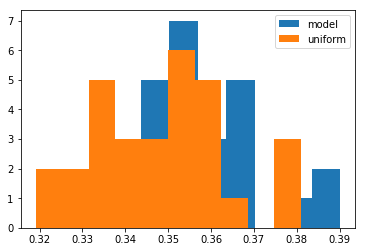

In [363]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));